In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, models, transforms
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset path and parameters
dataset_path = "F:\\Class\\FYP\\falseimage"
img_size = (224, 224)
batch_size = 32

# Define transforms (equivalent to TensorFlow's normalization)
data_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load dataset
dataset = datasets.ImageFolder(dataset_path, transform=data_transforms)

# Get class names
class_names = dataset.classes
print("Class Names:", class_names)

# Split dataset into train/val/test
indices = list(range(len(dataset)))
train_indices, temp_indices = train_test_split(
    indices, test_size=0.3, random_state=123, stratify=[dataset.targets[i] for i in indices]
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, random_state=123, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create data loaders
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

# Load ResNet50 (pretrained)
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze base model

# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

# Move model to device
model = model.to(device)

# Define loss, optimizer, and early stopping
criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

# Early stopping parameters
patience = 3
best_val_acc = 0.0
epochs_no_improve = 0
best_model_path = "resnet50_binary_model.pth"

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_acc = train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = val_correct / val_total
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

print("Training Complete. Best model saved as resnet50_binary_model.pth")

Class Names: ['nonpills', 'pills']


C:\Users\User\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10]
Train Loss: 0.1013, Train Acc: 0.9692
Val Loss: 0.0307, Val Acc: 0.9919
Saved best model
Epoch [2/10]
Train Loss: 0.0479, Train Acc: 0.9842
Val Loss: 0.0219, Val Acc: 0.9938
Saved best model
Epoch [3/10]
Train Loss: 0.0390, Train Acc: 0.9872
Val Loss: 0.0237, Val Acc: 0.9917
Epoch [4/10]
Train Loss: 0.0341, Train Acc: 0.9884
Val Loss: 0.0179, Val Acc: 0.9941
Saved best model
Epoch [5/10]
Train Loss: 0.0307, Train Acc: 0.9893
Val Loss: 0.0131, Val Acc: 0.9959
Saved best model
Epoch [6/10]
Train Loss: 0.0274, Train Acc: 0.9909
Val Loss: 0.0124, Val Acc: 0.9966
Saved best model
Epoch [7/10]
Train Loss: 0.0245, Train Acc: 0.9917
Val Loss: 0.0104, Val Acc: 0.9968
Saved best model
Epoch [8/10]
Train Loss: 0.0224, Train Acc: 0.9927
Val Loss: 0.0093, Val Acc: 0.9977
Saved best model
Epoch [9/10]
Train Loss: 0.0206, Train Acc: 0.9933
Val Loss: 0.0080, Val Acc: 0.9981
Saved best model
Epoch [10/10]
Train Loss: 0.0199, Train Acc: 0.9932
Val Loss: 0.0141, Val Acc: 0.9947
Training Comp

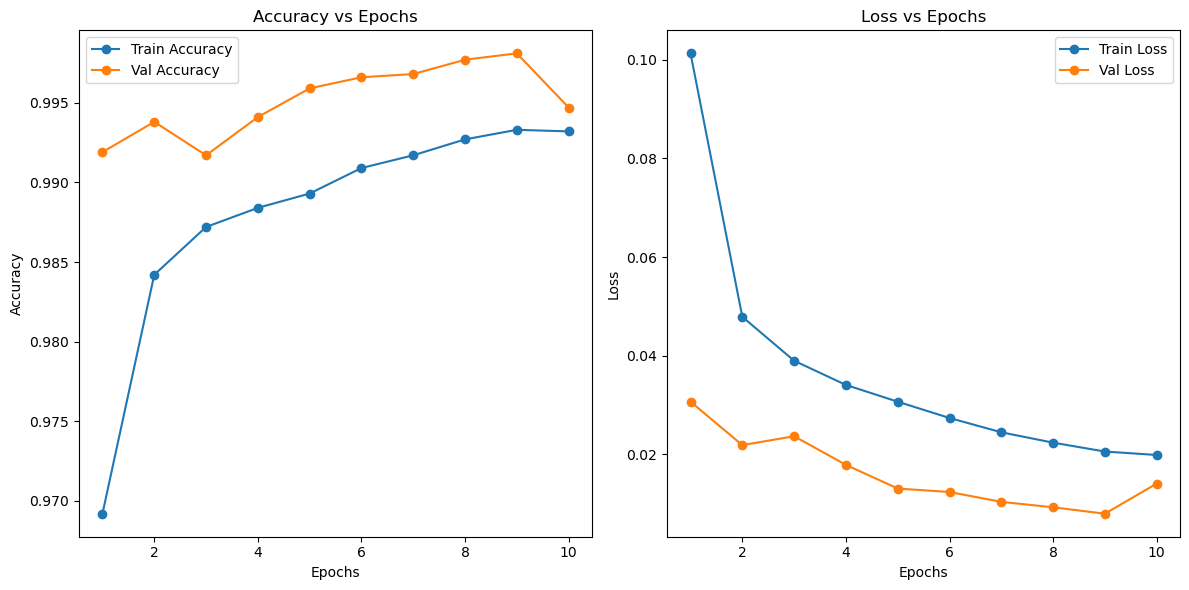

In [6]:
import matplotlib.pyplot as plt

# Data from the training log
epochs = list(range(1, 11))
train_losses = [0.1013, 0.0479, 0.0390, 0.0341, 0.0307, 0.0274, 0.0245, 0.0224, 0.0206, 0.0199]
val_losses = [0.0307, 0.0219, 0.0237, 0.0179, 0.0131, 0.0124, 0.0104, 0.0093, 0.0080, 0.0141]
train_accuracies = [0.9692, 0.9842, 0.9872, 0.9884, 0.9893, 0.9909, 0.9917, 0.9927, 0.9933, 0.9932]
val_accuracies = [0.9919, 0.9938, 0.9917, 0.9941, 0.9959, 0.9966, 0.9968, 0.9977, 0.9981, 0.9947]

# Create a plot for accuracy and loss over epochs
plt.figure(figsize=(12, 6))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs, val_accuracies, label="Val Accuracy", marker='o')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Val Loss", marker='o')
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
